In [1]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer import EM


true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.01123988 0.01207819 0.01155182 0.02688619 0.
 0.01019029 0.         0.         0.         0.01652657 0.0128754
 0.01306715 0.         0.01352577 0.         0.01099695 0.
 0.         0.01300062]


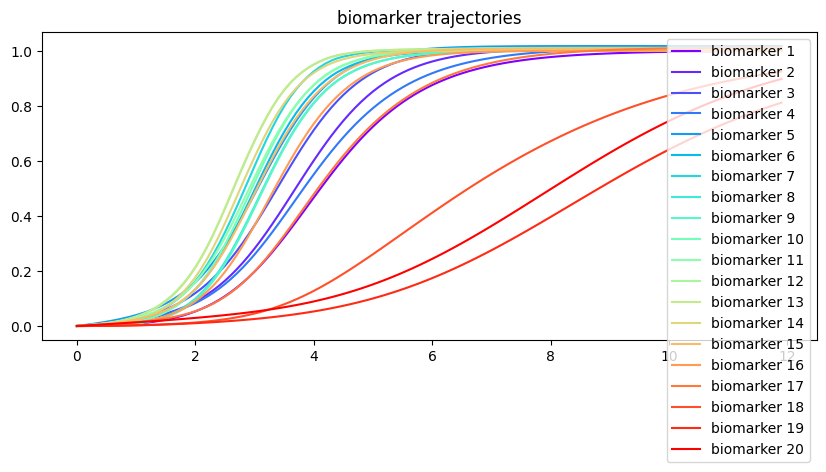

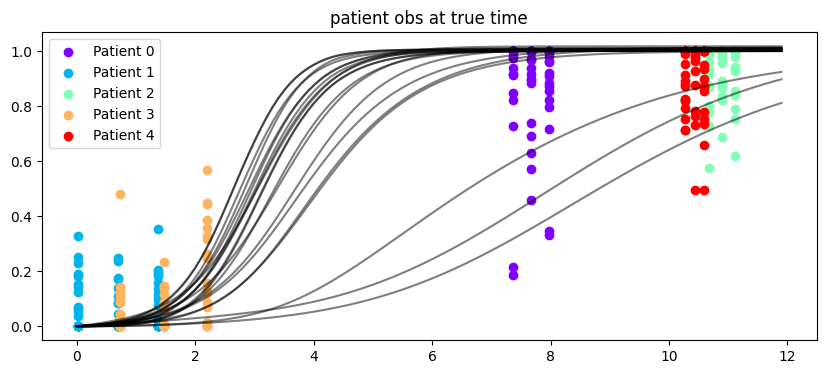

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824 0.07986404 0.05383256
 0.10993993 0.13257945 0.08262026 0.14778845 0.02372415 0.14300063
 0.0170779  0.10647585]
initial s: [2.79544046 1.30685669 0.19175346 0.80942044 2.73783142 2.61493628
 0.97118118 0.89594654 2.56627958 1.23194763 2.76895385 1.07435375
 2.58501779 1.07953042 1.76070828 2.50507976 0.17556968 1.85950923
 2.64783123 0.4718322 ]
initial scalar: 0.2251425668889057
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 17%|█▋        | 2/12 [00:12<01:04,  6.45s/it]

 92%|█████████▏| 11/12 [05:48<00:31, 31.72s/it]



SUMMARY:
best LSE at iteration 1: 761.683993504212
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01490907 0.16291554 0.08029182 0.184533
 0.15572293 0.19792942 0.02388094 0.10736655 0.1746095  0.11053824
 0.07986404 0.05383256 0.10993993 0.13257945 0.08262026 0.14778845
 0.02372415 0.14300063 0.0170779  0.10647585 2.79544046 1.30685669
 0.19175346 0.80942044 2.73783142 2.61493628 0.97118118 0.89594654
 2.56627958 1.23194763 2.76895385 1.07435375 2.58501779 1.07953042
 1.76070828 2.50507976 0.17556968 1.85950923 2.64783123 0.4718322
 0.22514257]
best theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01432366 0.1192756  0.01237178 0.01083317
 0.01845091 0.02758279

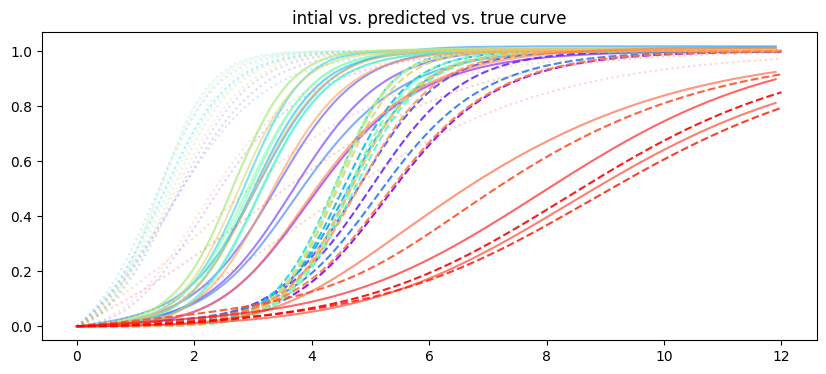

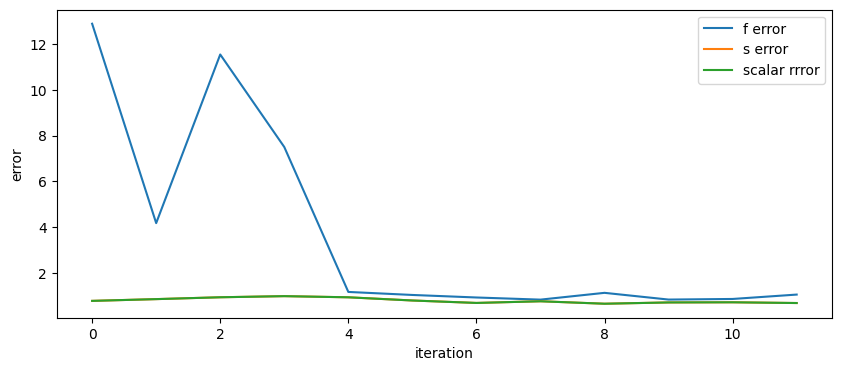

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


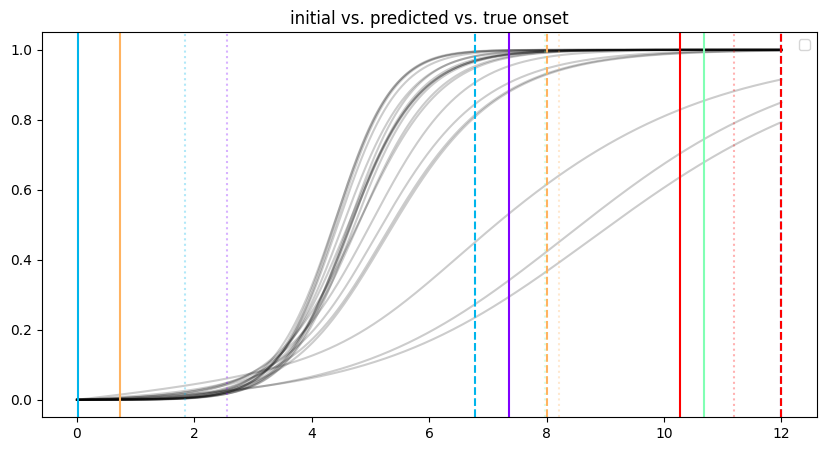

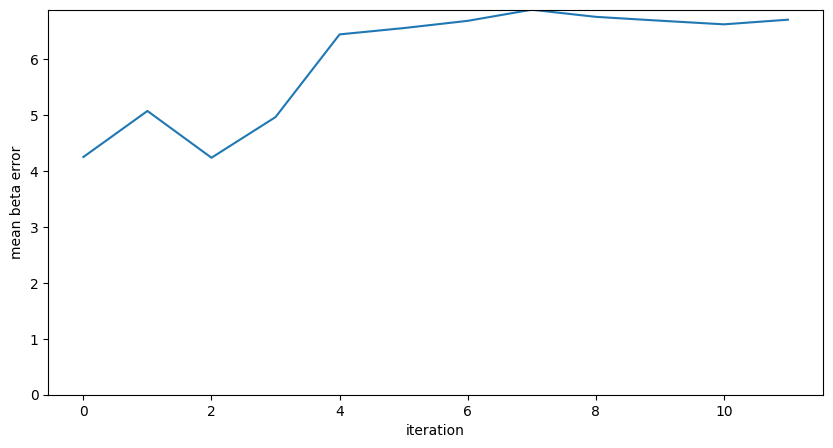

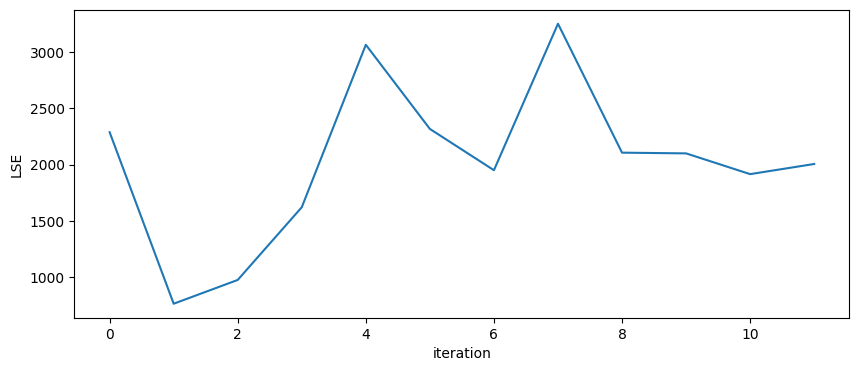

In [2]:
# params
n_biomarkers = 20
t_max = 12
t_span = np.linspace(0, t_max, 2000)
noise_level = 0.15
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

df, beta_true_dict = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)
plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=0.0,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 0.01

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824 0.07986404 0.05383256
 0.10993993 0.13257945 0.08262026 0.14778845 0.02372415 0.14300063
 0.0170779  0.10647585]
initial s: [2.79544046 1.30685669 0.19175346 0.80942044 2.73783142 2.61493628
 0.97118118 0.89594654 2.56627958 1.23194763 2.76895385 1.07435375
 2.58501779 1.07953042 1.76070828 2.50507976 0.17556968 1.85950923
 2.64783123 0.4718322 ]
initial scalar: 0.2251425668889057
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 33%|███▎      | 4/12 [01:00<02:09, 16.16s/it]

 92%|█████████▏| 11/12 [06:18<00:34, 34.44s/it]



SUMMARY:
best LSE at iteration 6: 534.0899335964523
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01490907 0.16291554 0.08029182 0.184533
 0.15572293 0.19792942 0.02388094 0.10736655 0.1746095  0.11053824
 0.07986404 0.05383256 0.10993993 0.13257945 0.08262026 0.14778845
 0.02372415 0.14300063 0.0170779  0.10647585 2.79544046 1.30685669
 0.19175346 0.80942044 2.73783142 2.61493628 0.97118118 0.89594654
 2.56627958 1.23194763 2.76895385 1.07435375 2.58501779 1.07953042
 1.76070828 2.50507976 0.17556968 1.85950923 2.64783123 0.4718322
 0.22514257]
best theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08192383 0.08026299 0.04247256
 0.12497558 0.1003600

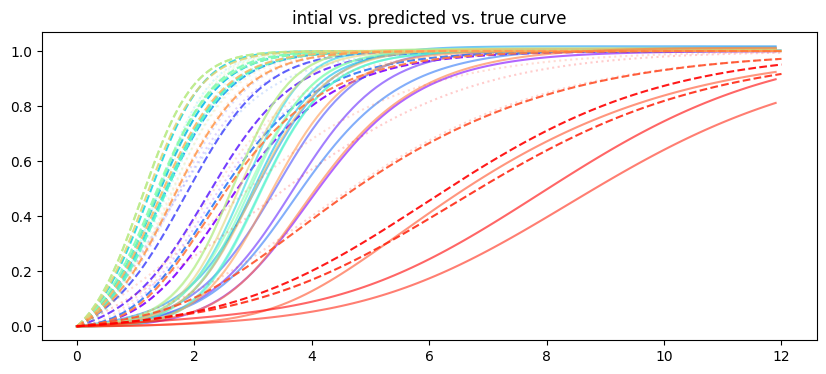

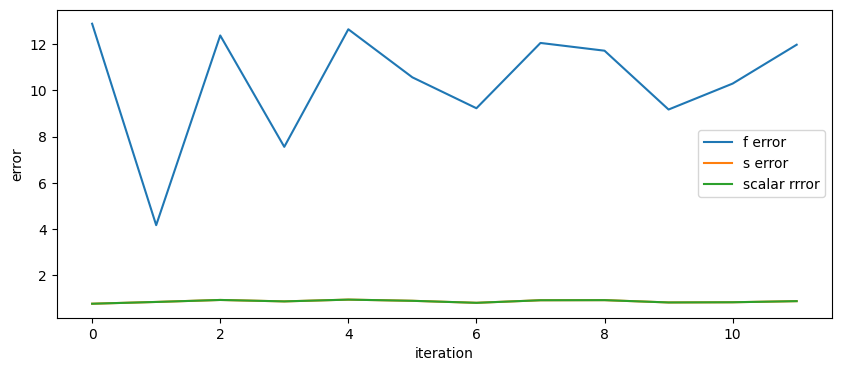

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


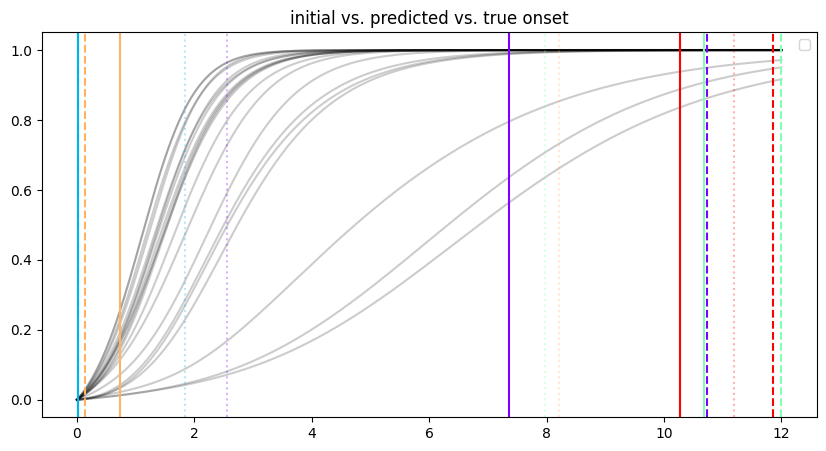

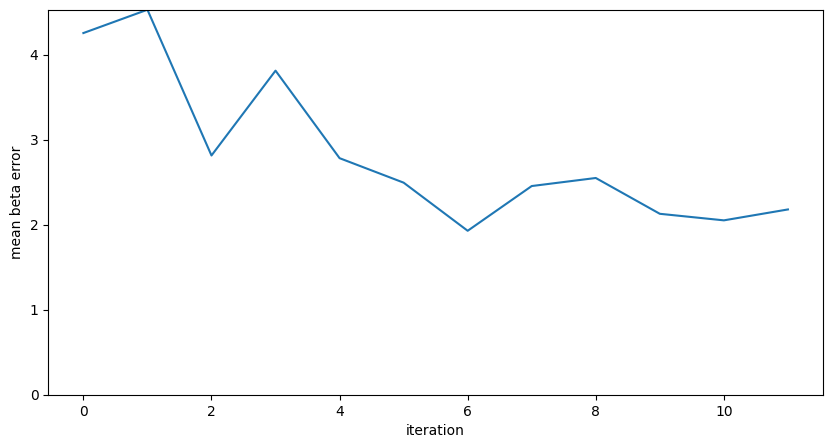

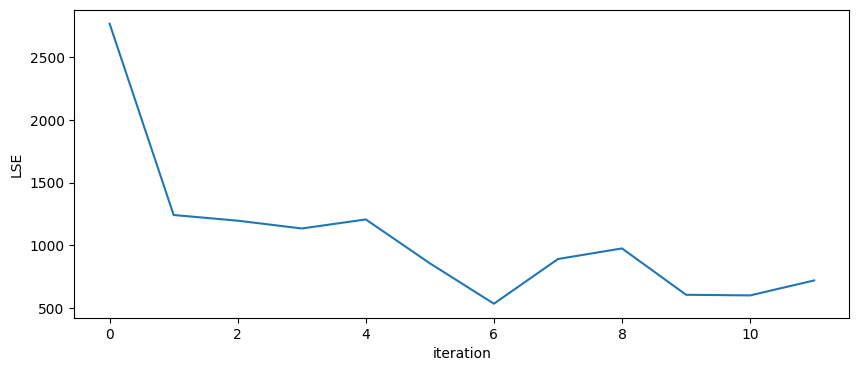

In [3]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=0.01,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 0.1

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824 0.07986404 0.05383256
 0.10993993 0.13257945 0.08262026 0.14778845 0.02372415 0.14300063
 0.0170779  0.10647585]
initial s: [2.79544046 1.30685669 0.19175346 0.80942044 2.73783142 2.61493628
 0.97118118 0.89594654 2.56627958 1.23194763 2.76895385 1.07435375
 2.58501779 1.07953042 1.76070828 2.50507976 0.17556968 1.85950923
 2.64783123 0.4718322 ]
initial scalar: 0.2251425668889057
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 25%|██▌       | 3/12 [00:38<01:52, 12.48s/it]

 92%|█████████▏| 11/12 [08:45<00:47, 47.74s/it]



SUMMARY:
best LSE at iteration 9: 196.95622608817482
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01490907 0.16291554 0.08029182 0.184533
 0.15572293 0.19792942 0.02388094 0.10736655 0.1746095  0.11053824
 0.07986404 0.05383256 0.10993993 0.13257945 0.08262026 0.14778845
 0.02372415 0.14300063 0.0170779  0.10647585 2.79544046 1.30685669
 0.19175346 0.80942044 2.73783142 2.61493628 0.97118118 0.89594654
 2.56627958 1.23194763 2.76895385 1.07435375 2.58501779 1.07953042
 1.76070828 2.50507976 0.17556968 1.85950923 2.64783123 0.4718322
 0.22514257]
best theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00

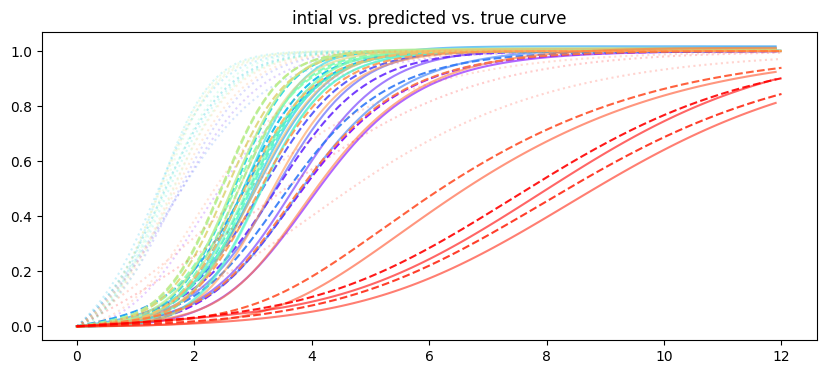

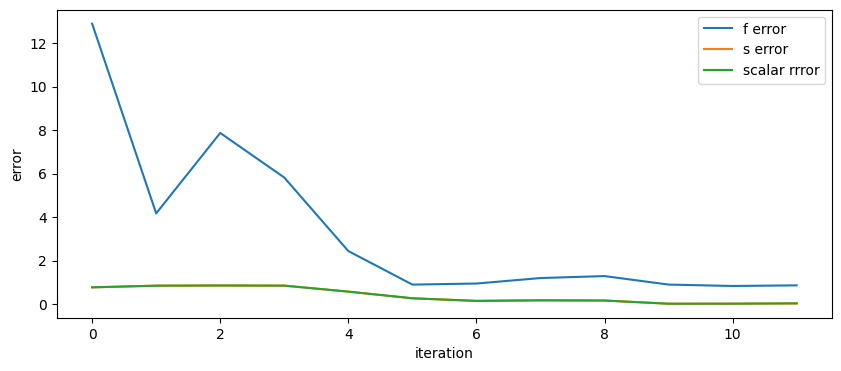

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


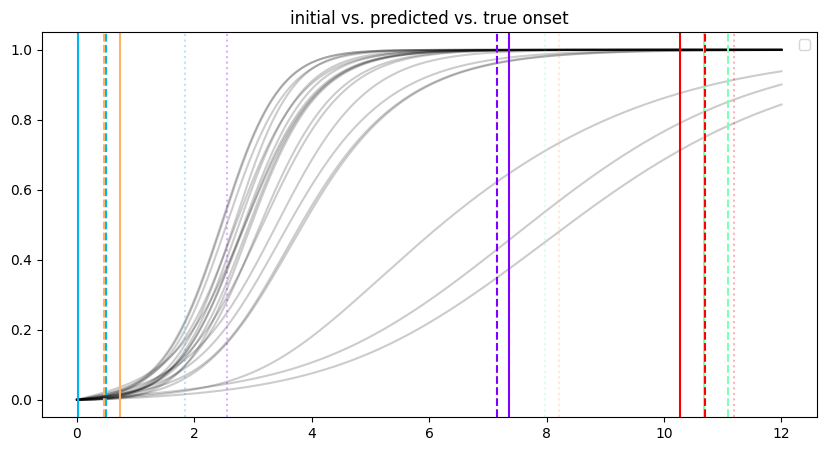

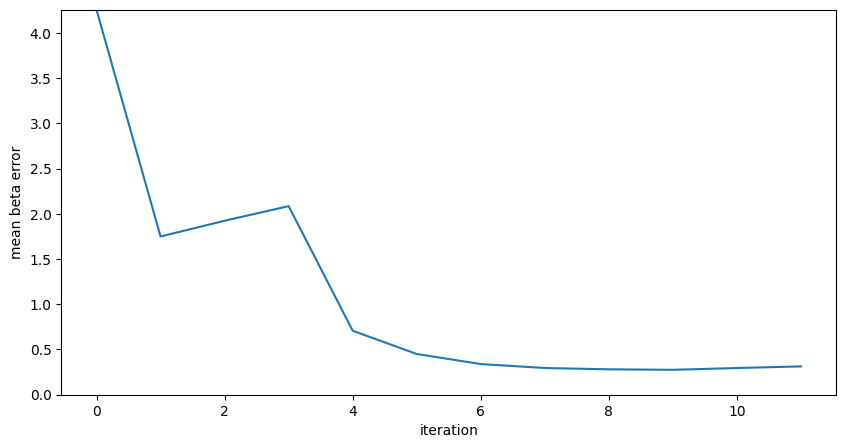

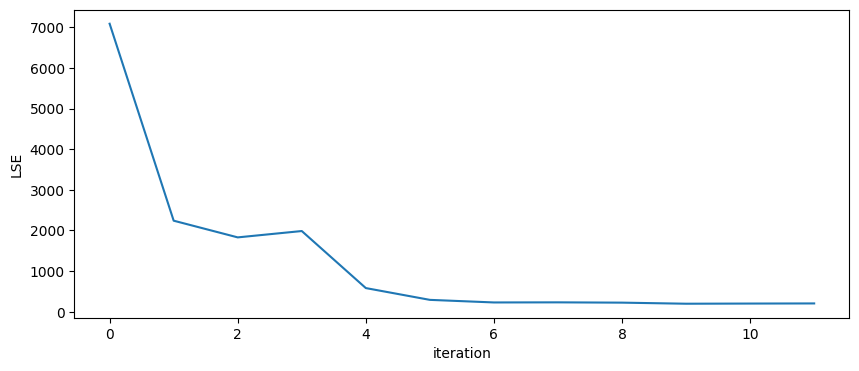

In [4]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=0.1,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 1.0

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824 0.07986404 0.05383256
 0.10993993 0.13257945 0.08262026 0.14778845 0.02372415 0.14300063
 0.0170779  0.10647585]
initial s: [2.79544046 1.30685669 0.19175346 0.80942044 2.73783142 2.61493628
 0.97118118 0.89594654 2.56627958 1.23194763 2.76895385 1.07435375
 2.58501779 1.07953042 1.76070828 2.50507976 0.17556968 1.85950923
 2.64783123 0.4718322 ]
initial scalar: 0.2251425668889057
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 92%|█████████▏| 11/12 [02:00<00:10, 10.92s/it]


SUMMARY:
best LSE at iteration 10: 1713.2134349258693
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01490907 0.16291554 0.08029182 0.184533
 0.15572293 0.19792942 0.02388094 0.10736655 0.1746095  0.11053824
 0.07986404 0.05383256 0.10993993 0.13257945 0.08262026 0.14778845
 0.02372415 0.14300063 0.0170779  0.10647585 2.79544046 1.30685669
 0.19175346 0.80942044 2.73783142 2.61493628 0.97118118 0.89594654
 2.56627958 1.23194763 2.76895385 1.07435375 2.58501779 1.07953042
 1.76070828 2.50507976 0.17556968 1.85950923 2.64783123 0.4718322
 0.22514257]
best theta:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01122575 0.14955661 0.08776605 0.04705364
 0.02094874 0.02393

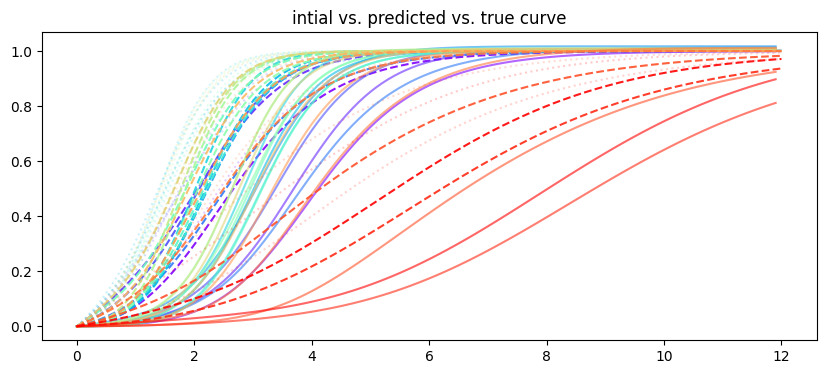

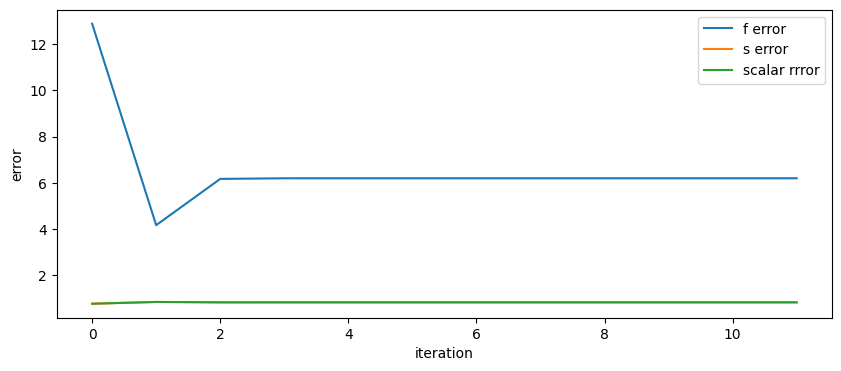

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


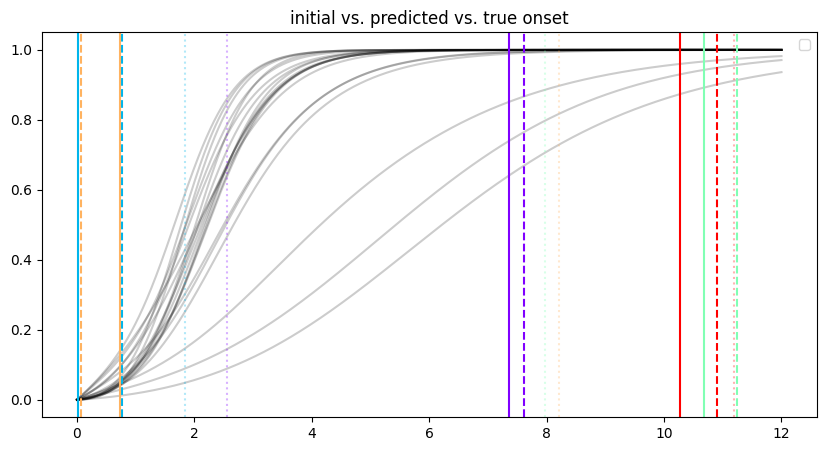

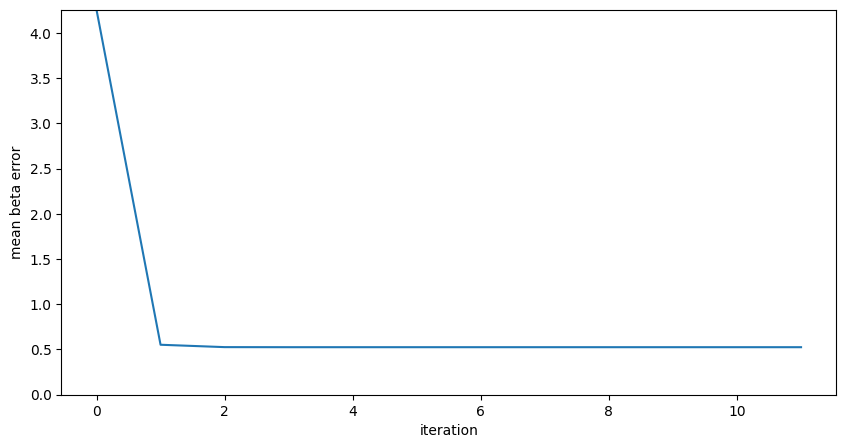

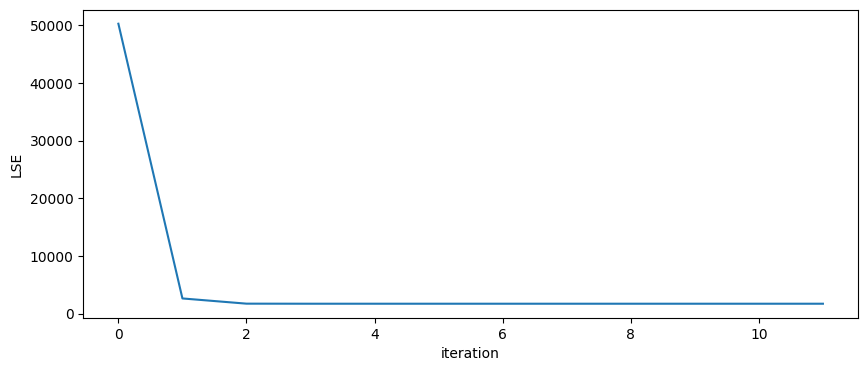

In [5]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=1.0,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)


## cog = 1.0

initial conditions:
initial f: [0.01490907 0.16291554 0.08029182 0.184533   0.15572293 0.19792942
 0.02388094 0.10736655 0.1746095  0.11053824 0.07986404 0.05383256
 0.10993993 0.13257945 0.08262026 0.14778845 0.02372415 0.14300063
 0.0170779  0.10647585]
initial s: [2.79544046 1.30685669 0.19175346 0.80942044 2.73783142 2.61493628
 0.97118118 0.89594654 2.56627958 1.23194763 2.76895385 1.07435375
 2.58501779 1.07953042 1.76070828 2.50507976 0.17556968 1.85950923
 2.64783123 0.4718322 ]
initial scalar: 0.2251425668889057
initial beta estimates (first 5 patients):    patient_id         0
0           0  2.559500
1           0  2.559500
2           0  2.559500
3           1  1.837549
4           1  1.837549
initial beta mean: 6.2177


 75%|███████▌  | 9/12 [01:24<00:28,  9.34s/it]

 92%|█████████▏| 11/12 [03:38<00:19, 19.87s/it]



SUMMARY:
best LSE at iteration 10: 340.5743283995114
initial theta
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01490907 0.16291554 0.08029182 0.184533
 0.15572293 0.19792942 0.02388094 0.10736655 0.1746095  0.11053824
 0.07986404 0.05383256 0.10993993 0.13257945 0.08262026 0.14778845
 0.02372415 0.14300063 0.0170779  0.10647585 2.79544046 1.30685669
 0.19175346 0.80942044 2.73783142 2.61493628 0.97118118 0.89594654
 2.56627958 1.23194763 2.76895385 1.07435375 2.58501779 1.07953042
 1.76070828 2.50507976 0.17556968 1.85950923 2.64783123 0.4718322
 0.22514257]
best theta:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00

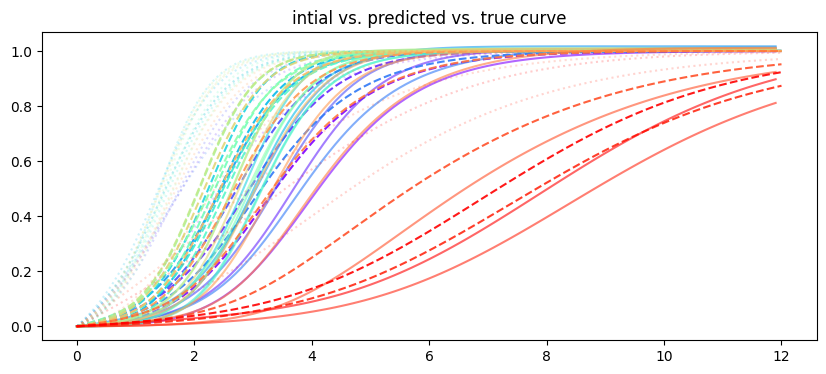

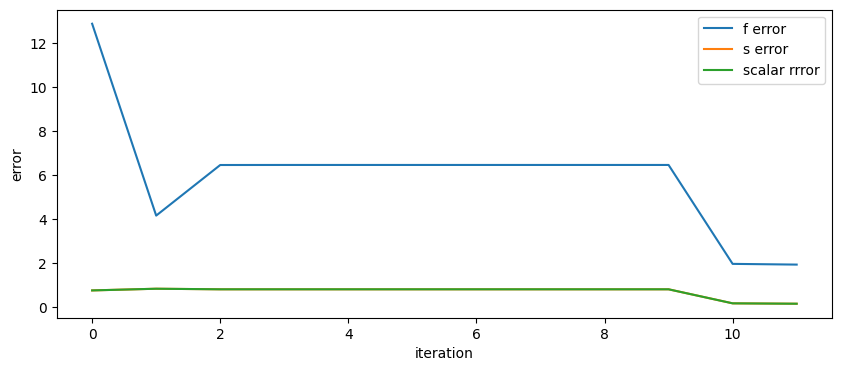

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


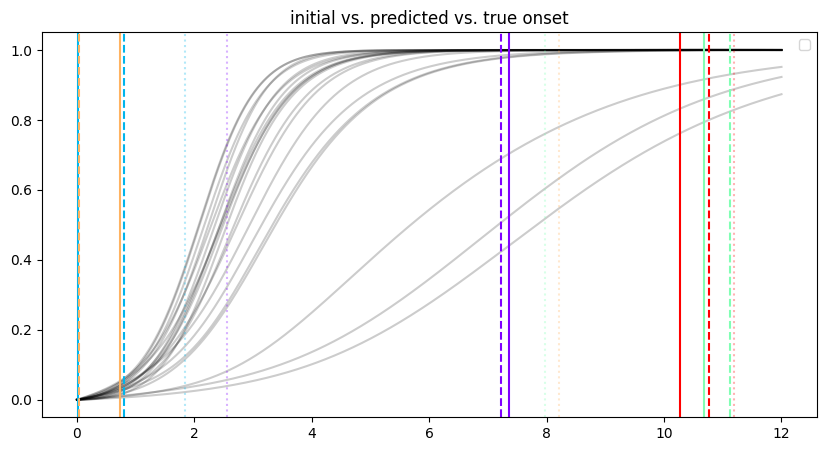

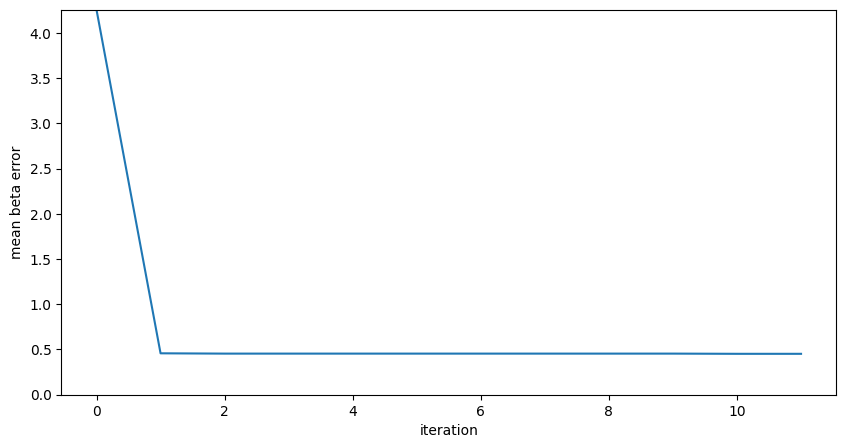

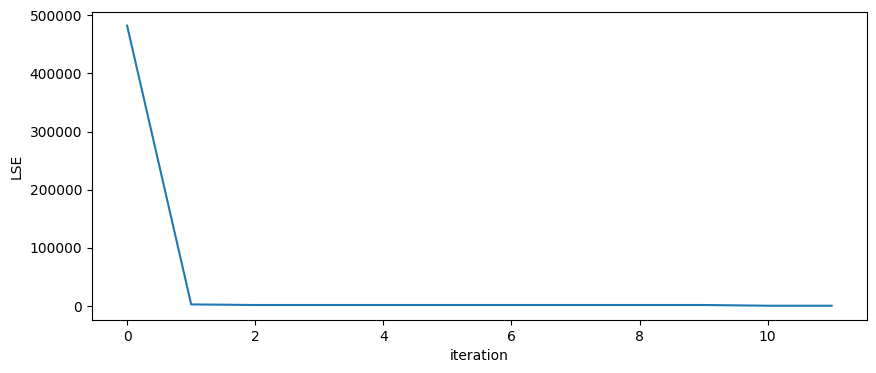

In [6]:
em_model_0 = EM(K=K,
              num_iterations=12,
              t_max=t_max,
              step=0.01,
              use_jacobian=True,
              lambda_cog=10.0,
              )

em_model_0.fit(df)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# final parameters
theta_final = em_model_0.theta_iter_[f"iter_{em_model_0.num_iterations - 1}"].values
x0_final = theta_final[:n_biomarkers]
f_final = theta_final[n_biomarkers:2*n_biomarkers]
x_final = solve_system(x0_final, f_final, K, t_span)

# initial parameters
theta_init = em_model_0.theta_iter_["iter_0"].values
x0_init = theta_init[:n_biomarkers]
f_init = theta_init[n_biomarkers:2*n_biomarkers]
x_init = solve_system(x0_init, f_init, K, t_span)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, x_init, x_final, n_biomarkers)
plot_theta_error_history(
    theta_iter=em_model_0.theta_iter_,
    n_biomarkers=n_biomarkers,
    num_iterations=em_model_0.num_iterations,
    f_true=f,
    s_true=np.ones(n_biomarkers),
    scalar_K_true=scalar_K
)
plot_beta_overlay(df, em_model_0.beta_iter_, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
plot_beta_error_history(em_model_0.beta_iter_, df, em_model_0.num_iterations)
plot_lse(em_model_0.lse_array_)
